# Neutralizer Thermocouple Analysis

## Overview
1. Loads thermocouple data from .lvm files
2. Detects heating events and calculates temperature rises (ΔT)
3. Fetches beam energy from MDSplus
4. Normalizes ΔT by beam energy for fair comparison across shots
5. Creates visualization plots

## It will load my path from ltxdata/users/Hussain (not my home dir but I believe people can access it)
  
- **Line ~240**: `base_out = Path("/u/hgajani/LTXb-py-main/LTXb-py-main/Ccal/Neutralizer/delta_t")`
  - Change this to where YOU want the summary text files saved as the code will load these files for the delta T data for the plotting and normalizing

#### In Cell 2 (Beam Energy Normalization):
- **Line ~15**: `output_dir = Path("/u/hgajani/LTXb-py-main/LTXb-py-main/Ccal/Neutralizer/delta_t")`
  - Change this to match the `base_out` path you set in Cell 1
  - This is where the script will look for summary files and save plots

### Step 2: Update MDSplus Toolbox Path (if needed)
In Cell 2, around line 12:
- `sys.path.append('/u/hgajani/LTXb-py-main/LTXb-py-main')`
  - Change this to wherever your `bills_LTX_MDSplus_toolbox.py` is located

Found 16 .lvm files to process (from /p/ltxdata/users/Hussain/neutralizer):
  - 10-14_515082.lvm
  - 10-14_515083.lvm
  - 10-14_515085.lvm
  - 12-14_515078.lvm
  - 12-14_515079.lvm
  - 12-14_515080.lvm
  - 4-14_112163.lvm
  - 4-14_515066.lvm
  - 4-14_515067.lvm
  - 4-14_515069.lvm
  - 6-14_515091.lvm
  - 6-14_515092.lvm
  - 6-14_515093.lvm
  - 8-14_515088.lvm
  - 8-14_515089.lvm
  - 8-14_515090.lvm
Loading 10-14_515082.lvm...
Loading 10-14_515083.lvm...
Loading 10-14_515085.lvm...
Loading 12-14_515078.lvm...
Loading 12-14_515079.lvm...
Loading 12-14_515080.lvm...
Loading 4-14_112163.lvm...
Loading 4-14_515066.lvm...
Loading 4-14_515067.lvm...
Loading 4-14_515069.lvm...
Loading 6-14_515091.lvm...
Loading 6-14_515092.lvm...
Loading 6-14_515093.lvm...
Loading 8-14_515088.lvm...
Loading 8-14_515089.lvm...
Loading 8-14_515090.lvm...

Heating event summary:
        file   TC            TC_Description  trigger_t  t1_min  t1_max   t2_t  deltaT1  deltaT2  deltaT
10-14_515082 TC14 NB Calorimeter

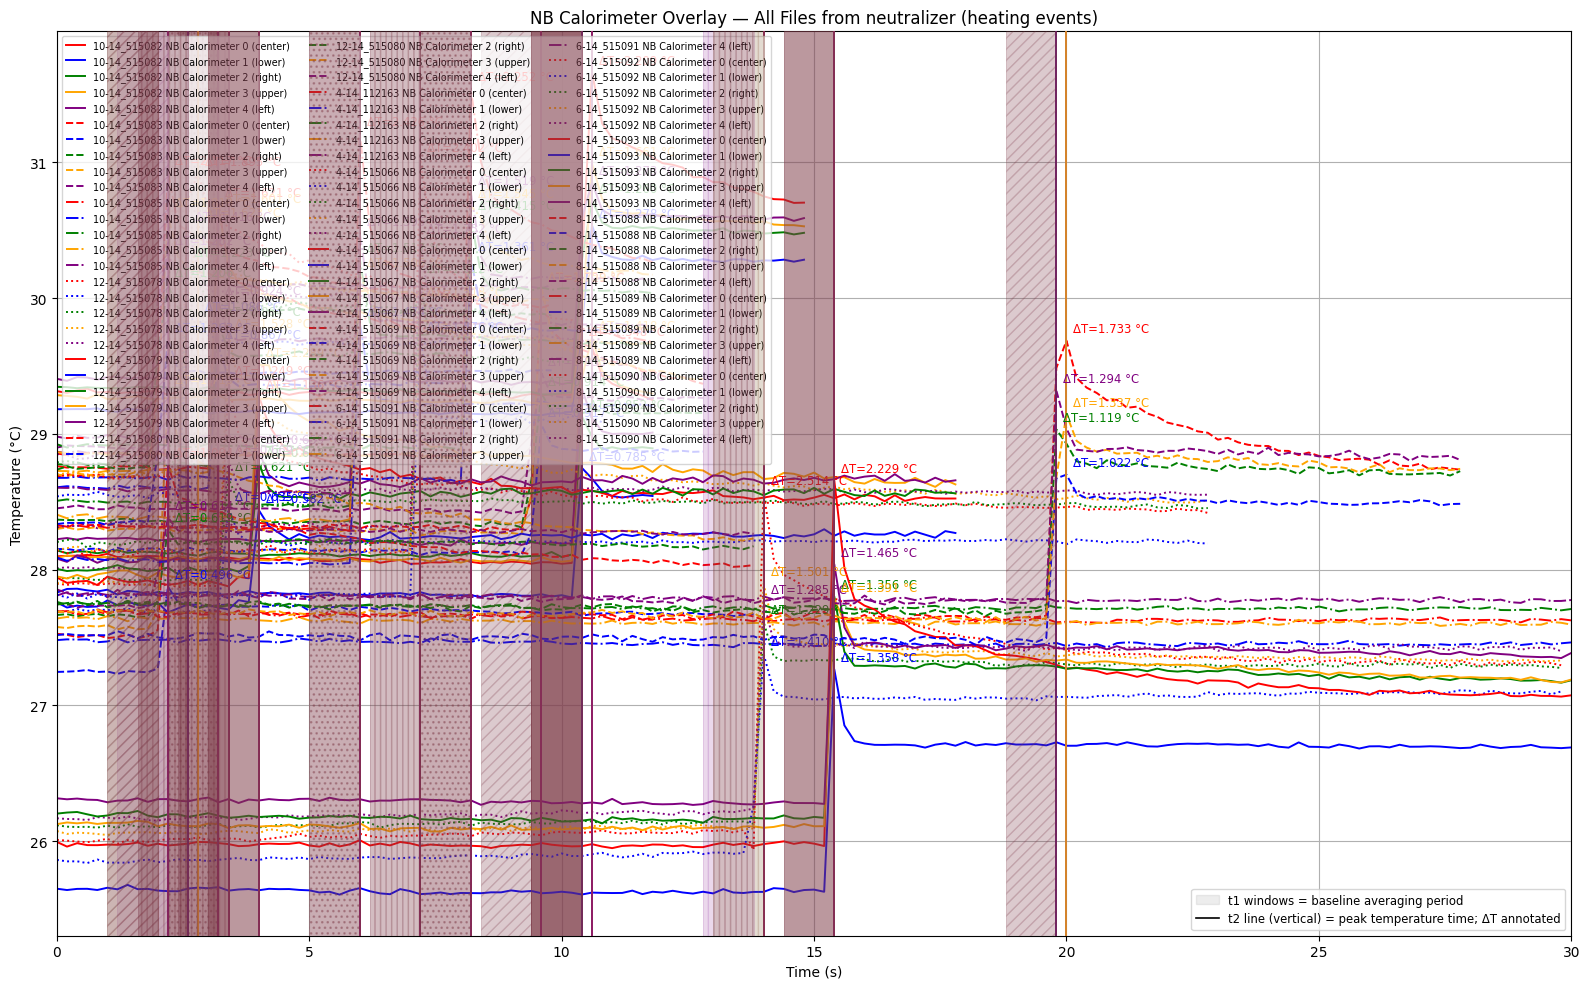

Wrote per-file summaries to: /u/hgajani/LTXb-py-main/LTXb-py-main/Ccal/Neutralizer/delta_t (sorted A-Z by filename)


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
# Path utilities
from pathlib import Path
import sys

# Data folder on P: drive where thermocouple .lvm files live
data_folder = Path('/p/ltxdata/users/Hussain/neutralizer')

# Check the data folder exists
if not data_folder.exists():
    print(f"Data folder not found: {data_folder}. Please check the path and try again.")
    sys.exit(1)

# Collect all .lvm files in the folder (no shot-list filtering) and sort A-Z
lvm_files = sorted(data_folder.glob('*.lvm'))
if not lvm_files:
    print(f"No .lvm files found in {data_folder}. Nothing to process.")
    sys.exit(0)

print(f"Found {len(lvm_files)} .lvm files to process (from {data_folder}):")
for f in lvm_files:
    print(f"  - {f.name}")

# time window AND Temp windows(s)
tmin, tmax = 0, 30 
ymin, ymax = None, None

# Mapping TC numbers 
TC_LABELS = {
    "TC14": "NB Calorimeter 0 (center)",
    "TC15": "NB Calorimeter 1 (lower)",
    "TC16": "NB Calorimeter 2 (right)",
    "TC17": "NB Calorimeter 3 (upper)",
    "TC18": "NB Calorimeter 4 (left)",
}

# Colors for each TC (assign actual color names)
TC_COLORS = {
    "TC14": "red",
    "TC15": "blue",
    "TC16": "green",
    "TC17": "orange",
    "TC18": "purple",
}

# data finding
def find_data_start(path: Path) -> int:
    """Find where LVM numeric data starts."""
    end_idx = -1
    with open(path, "r", errors="replace") as f:
        for i, line in enumerate(f):
            if line.strip() == "***End_of_Header***":
                end_idx = i
    if end_idx == -1:
        raise RuntimeError("Couldn't find ***End_of_Header*** in file.")
    return end_idx + 1


def load_lvm(path: Path):
    start_row = find_data_start(path)
    df = pd.read_csv(path, sep="\t", skiprows=start_row)
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]

    if "X_Value" not in df.columns:
        raise RuntimeError(f"X_Value column not found in {path}")

    time = pd.to_numeric(df["X_Value"], errors="coerce")

    tc_data = {}
    for num, label in TC_LABELS.items():
        col = f"Temperature_{int(num.replace('TC',''))}"
        if col in df.columns:
            tc_data[num] = pd.to_numeric(df[col], errors="coerce")

    return time, tc_data


# Load data for all files
all_file_data = {}
processed_count = 0
for lvm_file in lvm_files:
    print(f"Loading {lvm_file.name}...")
    try:
        time, data = load_lvm(lvm_file)
    except Exception as e:
        print(f"Skipping {lvm_file.name}: failed to load ({e}).")
        continue
    all_file_data[lvm_file.stem] = (time, data)
    processed_count += 1

if processed_count == 0:
    print("No .lvm files were successfully loaded. Exiting.")
    sys.exit(0)

def detect_heating_event(time: pd.Series, temp: pd.Series, rate_threshold: float = 0.2):
    #detect first heating event where |dT/dt| > rate_threshold.
    #Returns dict: trigger_t, t1_min, t1_max, t2_t, deltaT1, deltaT2, deltaT.
    
    time = pd.to_numeric(time, errors='coerce')
    temp = pd.to_numeric(temp, errors='coerce')

    dtemp = temp.diff()
    dt = time.diff()
    with np.errstate(divide='ignore', invalid='ignore'):
        rate = dtemp / dt

    cond = rate.abs() > rate_threshold
    if not cond.any():
        return {'trigger_t': None, 't1_min': None, 't1_max': None,
                't2_t': None, 'deltaT1': np.nan, 'deltaT2': np.nan, 'deltaT': np.nan}

    trigger_idx = cond[cond].index[0]
    trigger_t = float(time.iloc[trigger_idx])

    #1-second window prior to the trigger
    t1_min = trigger_t - 1.0
    t1_max = trigger_t

    mask_t1 = (time >= t1_min) & (time <= t1_max)
    deltaT1 = float(temp[mask_t1].mean()) if mask_t1.any() else np.nan

    #t2 is themax temperature for this thermocouple
    try:
        idx_t2 = temp.idxmax()
        t2_t = float(time.loc[idx_t2])
        deltaT2 = float(temp.loc[idx_t2])
    except Exception:
        t2_t = None
        deltaT2 = np.nan

    deltaT = np.nan if np.isnan(deltaT1) or np.isnan(deltaT2) else float(deltaT2 - deltaT1)

    return {'trigger_t': trigger_t, 't1_min': t1_min, 't1_max': t1_max,
            't2_t': t2_t, 'deltaT1': deltaT1, 'deltaT2': deltaT2, 'deltaT': deltaT}


def compute_global_trigger(time: pd.Series, data: dict) -> float | None:
    #per-shot trigger time using aggregate positive dT/dt.

    #Approach: build a DataFrame of all TCs, compute per-column derivative,
    #clip negative rates to 0, sum across TCs, and take the argmax time.
    #Returns None if data insufficient.
    #
    if not data:
        return None
    try:
        df = pd.DataFrame({k: pd.to_numeric(v, errors='coerce') for k, v in data.items()})
        # Align with time
        t = pd.to_numeric(time, errors='coerce')
        # Derivative per TC
        dt = t.diff()
        with np.errstate(divide='ignore', invalid='ignore'):
            rates = df.diff().divide(dt, axis=0)
        pos = rates.clip(lower=0)
        agg = pos.sum(axis=1)
        idx = agg.idxmax()
        if pd.isna(idx):
            return None
        return float(t.loc[idx])
    except Exception:
        return None


plt.figure(figsize=(16, 10))
ax = plt.gca()

# Define line styles for different files (cycle through them)
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']
fill_alphas = [0.14, 0.06, 0.10, 0.08]
hatches = ['', '///', '...', '|||']

rows = []
file_names = sorted(all_file_data.keys())  # Sort files A-Z

for file_idx, file_label in enumerate(file_names):
    time, data = all_file_data[file_label]
    linestyle = line_styles[file_idx % len(line_styles)]
    alpha = fill_alphas[file_idx % len(fill_alphas)]
    hatch = hatches[file_idx % len(hatches)]
    
    for num, pretty in TC_LABELS.items():
        color = TC_COLORS.get(num, 'black')
        if num not in data:
            rows.append({'file': file_label, 'TC': num, 'trigger_t': None,
                         't1_min': None, 't1_max': None, 't2_t': None,
                         'deltaT1': np.nan, 'deltaT2': np.nan, 'deltaT': np.nan})
            continue

        temp = data[num]
        # Always use per-TC detection with threshold 0.5 °C/s
        res = detect_heating_event(time, temp, rate_threshold=0.5)
        rows.append({**{'file': file_label, 'TC': num}, **res})

        ax.plot(time, temp, color=color, linestyle=linestyle, linewidth=1.4,
                label=f"{file_label} {pretty}")

        # Draw t1 window with different styles per file so overlaps remain visible
        if res['t1_min'] is not None and res['t1_max'] is not None:
            ax.axvspan(res['t1_min'], res['t1_max'], facecolor=color, alpha=alpha,
                       edgecolor=color, linewidth=0.6, hatch=hatch, zorder=2+file_idx)

        # Draw t2 as a vertical line (single moment) and annotate ΔT
        if res['t2_t'] is not None:
            ax.axvline(res['t2_t'], color=color, linestyle='-', linewidth=1.2, alpha=0.95, zorder=4)
            if pd.notna(res.get('deltaT')) and pd.notna(res.get('deltaT2')):
                ax.annotate(f"ΔT={res['deltaT']:.3f} °C",
                            xy=(res['t2_t'], res['deltaT2']), xytext=(5, 6),
                            textcoords='offset points', color=color, fontsize='small', zorder=5)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Temperature (°C)")
ax.set_title(f"NB Calorimeter Overlay — All Files from {data_folder.name} (heating events)")
ax.grid(True)

# Adjust the position of the legends
trace_legend = ax.legend(ncol=3, fontsize='x-small', loc='upper left', bbox_to_anchor=(0, 1))
ax.add_artist(trace_legend)

# Map TC to descriptive names in the summary table
df_res = pd.DataFrame(rows)
df_res['TC_Description'] = df_res['TC'].map(TC_LABELS)

# Add descriptive legend entries explaining the window styles and t2 meaning
l1_desc = 't2 line (vertical) = peak temperature time; ΔT annotated'
p1 = mpatches.Patch(facecolor='gray', alpha=0.14, edgecolor='gray', label="t1 windows = baseline averaging period")
l1 = mlines.Line2D([], [], color='black', linestyle='-', linewidth=1.2, label=l1_desc)
ax.legend(handles=[p1, l1], loc='lower right', fontsize='small')

# Print updated summary table
cols = ['file', 'TC', 'TC_Description', 'trigger_t', 't1_min', 't1_max', 't2_t', 'deltaT1', 'deltaT2', 'deltaT']
df_res = df_res[cols]
pd.set_option('display.float_format', lambda x: f"{x:.3f}" if pd.notna(x) else "nan")
print('\nHeating event summary:')
print(df_res.to_string(index=False))

if ymin is not None and ymax is not None:
    ax.set_ylim(ymin, ymax)
ax.set_xlim(tmin, tmax)
plt.tight_layout()
plt.show()

# ======= WRITE PER-FILE SUMMARY TEXTS =======
# Base output directory (must exist)
base_out = Path("/u/hgajani/LTXb-py-main/LTXb-py-main/Ccal/Neutralizer/delta_t")
if not base_out.exists():
    base_out.mkdir(parents=True, exist_ok=True)

# For each input file create a text file with that file's rows from the summary
# Sort filenames alphabetically A-Z
sorted_files = sorted(df_res['file'].unique())

for fname in sorted_files:
    group = df_res[df_res['file'] == fname]
    out_path = base_out / f"{fname}_summary.txt"
    with open(out_path, 'w', encoding='utf-8') as f:
        f.write(f"Heating event summary for {fname}\n")
        f.write("=" * (24 + len(fname)))
        f.write("\n\n")
        # Use the same float formatting as printed to console
        f.write(group.to_string(index=False))

print(f"Wrote per-file summaries to: {base_out} (sorted A-Z by filename)")





=== Fetching beam energies from MDSplus ===
Shot 515082 (10-14_515082): 2.11 kJ
Shot 515083 (10-14_515083): 2.15 kJ
Shot 515085 (10-14_515085): 2.15 kJ
Shot 515078 (12-14_515078): 2.16 kJ
Shot 515079 (12-14_515079): 2.16 kJ
Shot 515080 (12-14_515080): 2.19 kJ
Shot 112163 (4-14_112163): 1.91 kJ
Shot 515066 (4-14_515066): 1.94 kJ
Shot 515067 (4-14_515067): 1.88 kJ
Shot 515069 (4-14_515069): 1.86 kJ
Shot 515091 (6-14_515091): 2.01 kJ
Shot 515092 (6-14_515092): 2.16 kJ
Skipping shot 515093 (6-14_515093): known outlier
Shot 515088 (8-14_515088): 2.22 kJ
Shot 515089 (8-14_515089): 2.13 kJ
Shot 515090 (8-14_515090): 2.13 kJ

=== Reading summary files ===
Shot 515066 (4-14_515066): 1.94 kJ
Shot 515067 (4-14_515067): 1.88 kJ
Shot 515069 (4-14_515069): 1.86 kJ
Shot 515091 (6-14_515091): 2.01 kJ
Shot 515092 (6-14_515092): 2.16 kJ
Skipping shot 515093 (6-14_515093): known outlier
Shot 515088 (8-14_515088): 2.22 kJ
Shot 515089 (8-14_515089): 2.13 kJ
Shot 515090 (8-14_515090): 2.13 kJ

=== Reading 


Saved plot to /u/hgajani/LTXb-py-main/LTXb-py-main/Ccal/Neutralizer/delta_t/shot_index_deltaT_combined_normalized.png


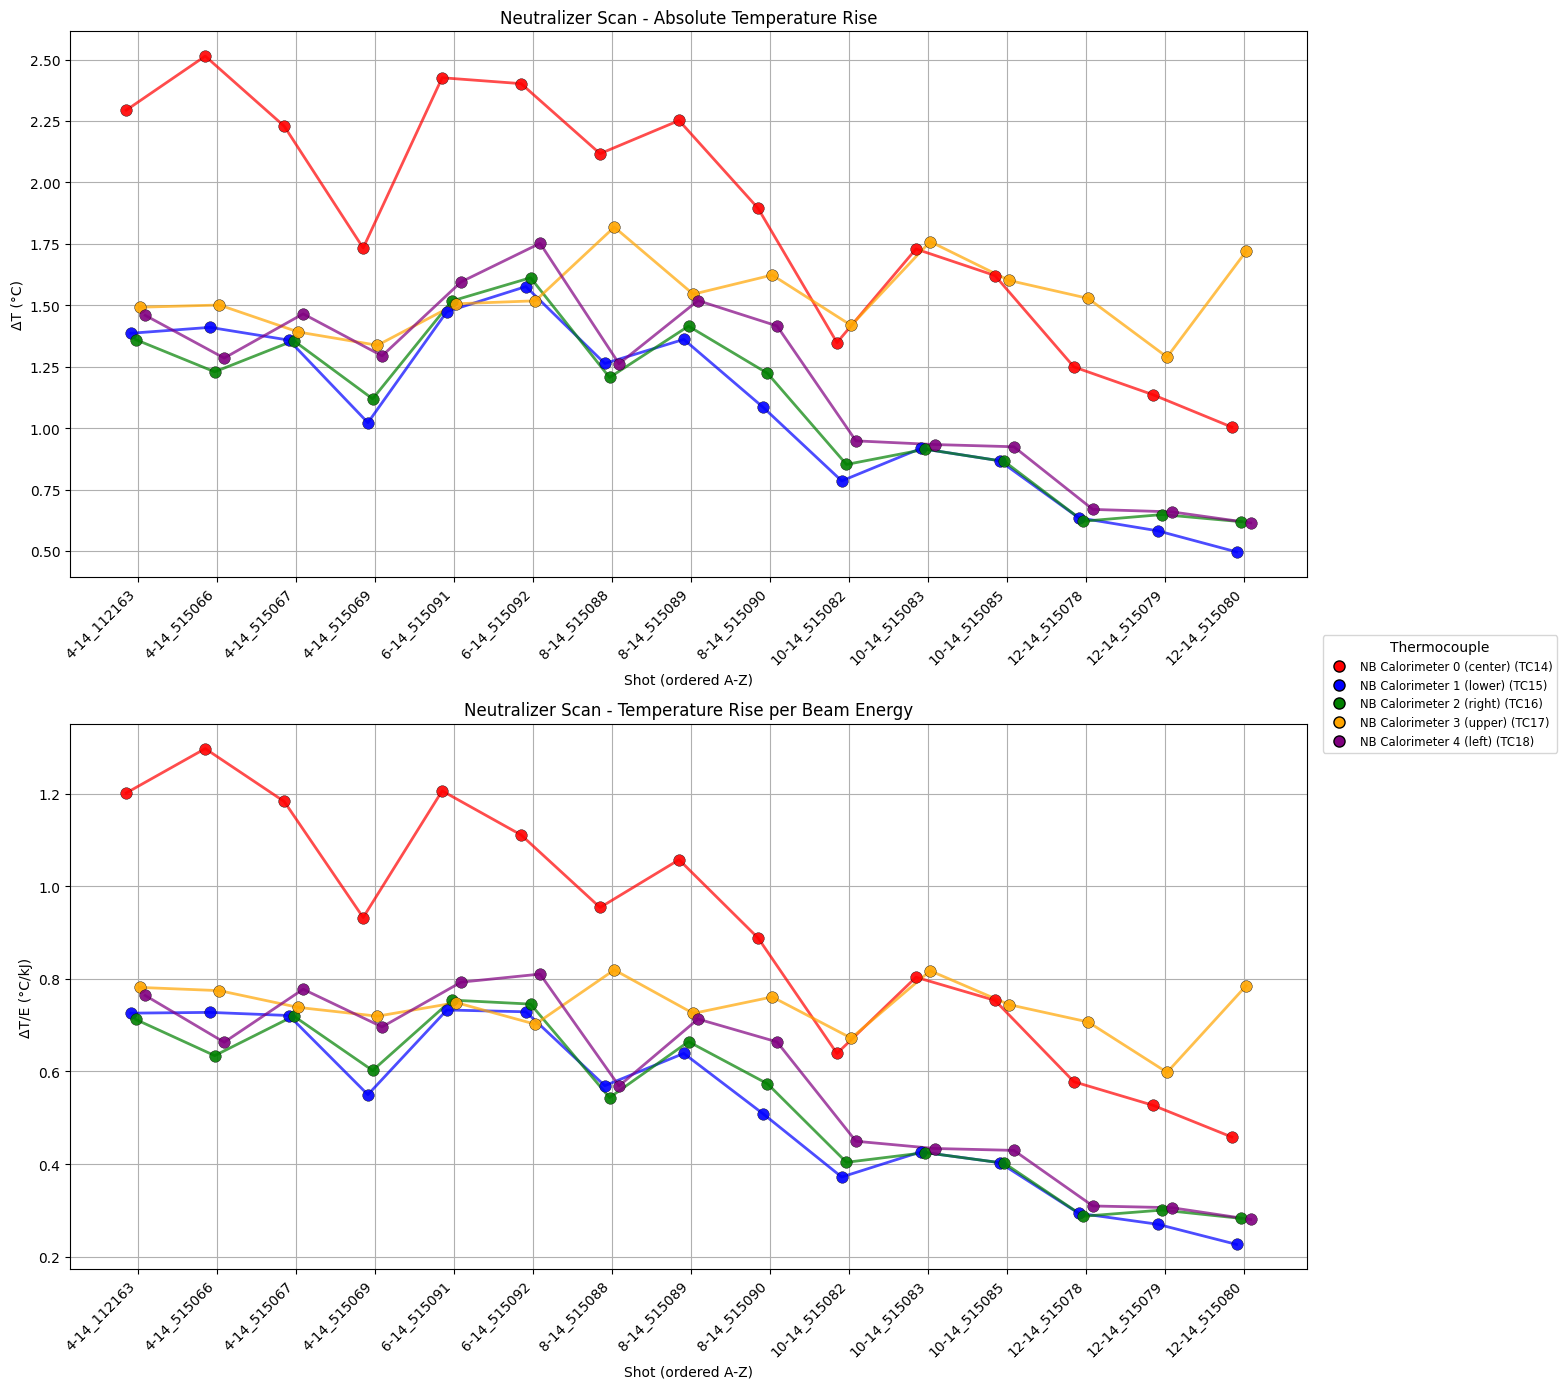


=== Summary Statistics ===

Average values across all shots:
  TC14: ΔT = 1.86 °C, ΔT/E = 0.9059 °C/kJ
  TC15: ΔT = 1.08 °C, ΔT/E = 0.5262 °C/kJ
  TC16: ΔT = 1.10 °C, ΔT/E = 0.5366 °C/kJ
  TC17: ΔT = 1.54 °C, ΔT/E = 0.7395 °C/kJ
  TC18: ΔT = 1.19 °C, ΔT/E = 0.5771 °C/kJ


In [43]:
#!/usr/bin/env python3
"""
This script reads all the thermocouple summary files, fetches beam energy from MDSplus,
and creates plots showing both absolute and normalized temperature changes.
"""

import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import re

# MDSplus setup for fetching beam diagnostics
sys.path.append('/u/hgajani/LTXb-py-main/LTXb-py-main')
from bills_LTX_MDSplus_toolbox import get_tree_conn, get_data
import MDSplus as mds

# Where the summary files are stored
output_dir = Path("/u/hgajani/LTXb-py-main/LTXb-py-main/Ccal/Neutralizer/delta_t")
if not output_dir.exists():
    print(f"Can't find folder: {output_dir}")
    sys.exit(1)

# Get all the summary text files
summary_files = sorted(output_dir.glob("*_summary.txt"))

if not summary_files:
    print("No summary files found")
    sys.exit(1)


def get_beam_energy(shot_number, voltage_threshold=5000.0):
    """
    Fetch total beam energy from MDSplus by integrating power over time.
    Returns energy in kJ.
    """
    try:
        # Figure out which tree to use based on shot number
        if shot_number > 200000:
            tree_name = 'ltx_nbi'
            node_prefix = ''
        else:
            tree_name = 'ltx_b'
            node_prefix = '.oper_diags.ltx_nbi'
        
        tree = get_tree_conn(shot_number, treename=tree_name)
        (time_current, current) = get_data(tree, f'{node_prefix}.source_diags.i_hvps')
        (time_voltage, voltage) = get_data(tree, f'{node_prefix}.source_diags.v_hvps')
        
        # Match current to voltage time base
        current = np.interp(time_voltage, time_current, current)
        power = current * voltage / 1000.0  # Convert to kW
        
        # Only integrate when beam is actually on (voltage > threshold)
        beam_on = voltage > voltage_threshold
        if np.any(beam_on):
            time_on = time_voltage[beam_on]
            power_on = power[beam_on]
            total_energy = np.trapz(power_on, time_on)  # kJ
            return total_energy
        else:
            return np.nan
            
    except (mds.mdsExceptions.TreeNODATA, Exception) as e:
        print(f'Warning: Could not fetch beam power for shot {shot_number}: {e}')
        return np.nan


def parse_summary_file(filepath: Path) -> pd.DataFrame:
    """Read and parse a summary text file into a DataFrame."""
    text = filepath.read_text(encoding='utf-8')
    lines = text.splitlines()

    # Find where the data table starts
    header_line = None
    for i, line in enumerate(lines):
        if 'TC_Description' in line or re.search(r'\bfile\b', line):
            header_line = i
            break

    table_text = []
    if header_line is not None and header_line + 1 < len(lines):
        table_text = lines[header_line:]
        try:
            df = pd.read_fwf(io.StringIO('\n'.join(table_text)))
            if 'deltaT' in df.columns:
                return df
        except Exception:
            pass

    # Backup parser if the fixed-width parsing fails
    data_rows = []
    for line in lines:
        if not line.strip():
            continue
        if re.match(r"^\s*\d", line) or re.match(r"^\s*\w", line):
            if 'Heating event summary' in line:
                continue
            data_rows.append(line)

    parsed_data = []
    for line in data_rows:
        tokens = line.strip().split()
        if len(tokens) < 3:
            continue
        
        filename = tokens[0]
        tc_name = tokens[1]
        
        # Find where the numbers start
        first_number_idx = None
        for j in range(2, len(tokens)):
            if re.match(r'^[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?$', tokens[j]):
                first_number_idx = j
                break
        
        if first_number_idx is None:
            continue
        
        description = ' '.join(tokens[2:first_number_idx])
        numbers = tokens[first_number_idx:]
        
        # Extract the 7 numeric columns we expect
        num_values = [float(x) for x in numbers[:7]] + [np.nan] * max(0, 7 - len(numbers))
        
        parsed_data.append({
            'file': filename,
            'TC': tc_name,
            'TC_Description': description,
            'trigger_t': num_values[0],
            't1_min': num_values[1],
            't1_max': num_values[2],
            't2_t': num_values[3],
            'deltaT1': num_values[4],
            'deltaT2': num_values[5],
            'deltaT': num_values[6],
        })

    if parsed_data:
        return pd.DataFrame(parsed_data)
    
    return pd.DataFrame()


# Storage for all the data
all_data = []
beam_energies = {}

# Fetch beam energies from MDSplus
print("\n=== Fetching beam energies from MDSplus ===")
for filepath in summary_files:
    filename = filepath.stem.replace("_summary", "")
    
    # Pull out the 6-digit shot number from the filename
    shot_match = re.search(r'(\d{6})', filename)
    if shot_match:
        shot_num = int(shot_match.group(1))
        
        # Skip shot 515093 (outlier with tiny beam energy)
        if shot_num == 515093:
            print(f"Skipping shot {shot_num} ({filename}): known outlier")
            beam_energies[filename] = np.nan
            continue
        
        energy = get_beam_energy(shot_num)
        beam_energies[filename] = energy
        
        if not np.isnan(energy):
            print(f"Shot {shot_num} ({filename}): {energy:.2f} kJ")
        else:
            print(f"Shot {shot_num} ({filename}): No data available")
    else:
        print(f"Warning: Couldn't extract shot number from {filename}")
        beam_energies[filename] = np.nan

# Parse all the summary files
print("\n=== Reading summary files ===")
for filepath in summary_files:
    df = parse_summary_file(filepath)
    if df.empty:
        print(f'Warning: could not parse {filepath}')
        continue
    
    filename = filepath.stem.replace("_summary", "")
    
    # Skip 515093 data
    shot_match = re.search(r'(\d{6})', filename)
    if shot_match and int(shot_match.group(1)) == 515093:
        continue
    
    df['file'] = filename
    df['group'] = 'shot'
    
    # Add beam energy and calculate normalized temperature rise
    energy = beam_energies.get(filename, np.nan)
    df['beam_energy_kJ'] = energy
    df['deltaT_norm'] = df['deltaT'] / energy if not np.isnan(energy) else np.nan
    
    all_data.append(df)

# Combine everything into one DataFrame
data = pd.concat(all_data, ignore_index=True, sort=False)

# Make sure all the temperature columns are numeric
for col in ['deltaT', 'deltaT2', 'deltaT1', 'deltaT_norm']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

if 'deltaT' not in data.columns:
    print(f'Error: deltaT column not found. Available columns: {data.columns.tolist()}')
    sys.exit(1)

# Sort files naturally (handles numbers correctly)
def natural_sort_key(text):
    """Split text into number and string parts for natural sorting."""
    def try_int(s):
        try:
            return int(s)
        except ValueError:
            return s.lower()
    
    return [try_int(c) for c in re.split(r'(\d+)', text)]

unique_files = list(data['file'].unique())
file_order = sorted(unique_files, key=natural_sort_key)

print("\nFile order (A-Z with natural number sorting):")
for i, filename in enumerate(file_order):
    energy = beam_energies.get(filename, np.nan)
    energy_str = f"{energy:.2f} kJ" if not np.isnan(energy) else "No data"
    print(f"  {i}: {filename} ({energy_str})")

# Create index mapping for plotting
file_to_idx = {f: i for i, f in enumerate(file_order)}
data['shot_idx'] = data['file'].map(file_to_idx)

# Thermocouple info
tc_labels = {
    "TC14": "NB Calorimeter 0 (center)",
    "TC15": "NB Calorimeter 1 (lower)",
    "TC16": "NB Calorimeter 2 (right)",
    "TC17": "NB Calorimeter 3 (upper)",
    "TC18": "NB Calorimeter 4 (left)",
}
tc_colors = {
    "TC14": "red",
    "TC15": "blue",
    "TC16": "green",
    "TC17": "orange",
    "TC18": "purple",
}

# Create two subplots: absolute ΔT and normalized ΔT/E
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(16, 14))

tc_list = sorted(data['TC'].unique()) if 'TC' in data.columns else []

# Top plot: Absolute temperature rise
for i, tc in enumerate(tc_list):
    tc_data = data[data['TC'] == tc]
    color = tc_colors.get(tc, 'gray')
    
    # Small offset so different TCs don't overlap exactly
    offset = (i - len(tc_list)/2) * 0.06
    
    shot_data = tc_data[tc_data['group'] == 'shot']
    if not shot_data.empty:
        shot_data = shot_data.sort_values('shot_idx')
        x_pos = shot_data['shot_idx'].to_numpy() + offset
        y_vals = shot_data['deltaT'].to_numpy()
        
        # Draw lines connecting the points
        ax_top.plot(x_pos, y_vals, color=color, linewidth=2, alpha=0.7, linestyle='-')
        # Add markers on top
        ax_top.scatter(x_pos, y_vals, s=70, alpha=0.9, c=color, marker='o', 
                      edgecolor='k', linewidth=0.3, zorder=5)

# Bottom plot: Normalized by beam energy
for i, tc in enumerate(tc_list):
    tc_data = data[data['TC'] == tc]
    color = tc_colors.get(tc, 'gray')
    offset = (i - len(tc_list)/2) * 0.06
    
    shot_data = tc_data[tc_data['group'] == 'shot']
    if not shot_data.empty:
        shot_data = shot_data.sort_values('shot_idx')
        x_pos = shot_data['shot_idx'].to_numpy() + offset
        y_vals = shot_data['deltaT_norm'].to_numpy()
        
        ax_bottom.plot(x_pos, y_vals, color=color, linewidth=2, alpha=0.7, linestyle='-')
        ax_bottom.scatter(x_pos, y_vals, s=70, alpha=0.9, c=color, marker='o',
                         edgecolor='k', linewidth=0.3, zorder=5)

# Format top plot
ax_top.set_xticks(list(range(len(file_order))))
ax_top.set_xticklabels(file_order, rotation=45, ha='right')
ax_top.set_xlabel('Shot (ordered A-Z)')
ax_top.set_ylabel('ΔT (°C)')
ax_top.set_title('Neutralizer Scan - Absolute Temperature Rise')
ax_top.grid(True)

# Format bottom plot
ax_bottom.set_xticks(list(range(len(file_order))))
ax_bottom.set_xticklabels(file_order, rotation=45, ha='right')
ax_bottom.set_xlabel('Shot (ordered A-Z)')
ax_bottom.set_ylabel('ΔT/E (°C/kJ)')
ax_bottom.set_title('Neutralizer Scan - Temperature Rise per Beam Energy')
ax_bottom.grid(True)

# Make room for the legend
fig.tight_layout()
fig.subplots_adjust(right=0.82)

# Create legend with TC descriptions
from matplotlib.lines import Line2D
legend_items = []
tc_order = ['TC14', 'TC15', 'TC16', 'TC17', 'TC18']
for tc in tc_order:
    label = tc_labels.get(tc, tc)
    color = tc_colors.get(tc, 'gray')
    legend_items.append(
        Line2D([0], [0], marker='o', color='w', 
               label=f"{label} ({tc})", 
               markerfacecolor=color, markersize=8, markeredgecolor='k')
    )

# Put legend on the right side
fig.legend(handles=legend_items, title='Thermocouple', 
          loc='center right', bbox_to_anchor=(0.98, 0.5), 
          fontsize='small', frameon=True)

# Save the figure
output_file = output_dir / 'shot_index_deltaT_combined_normalized.png'
fig.savefig(output_file, dpi=200, bbox_inches='tight')
print(f'\nSaved plot to {output_file}')
plt.show()

# Print summary stats
print("\n=== Summary Statistics ===")
print(f"\nAverage values across all shots:")
for tc in tc_order:
    tc_subset = data[data['TC'] == tc]
    avg_temp = tc_subset['deltaT'].mean()
    avg_norm = tc_subset['deltaT_norm'].mean()
    print(f"  {tc}: ΔT = {avg_temp:.2f} °C, ΔT/E = {avg_norm:.4f} °C/kJ")



DETAILED ANALYSIS OF SHOT 6-14_515093 (shot number: 515093)

=== TREE SELECTION CHECK ===
Shot number: 515093
✓ Shot 515093 > 200000, so using 'ltx_nbi' tree
Tree: ltx_nbi
Prefix: ''
Full path for current: .source_diags.i_hvps

=== MANUAL BEAM ENERGY FETCH ===
✓ Successfully connected to tree 'ltx_nbi' for shot 515093
✓ Got current data: 470 points, range [-6.84, 5.22] A
✓ Got voltage data: 470 points, range [-99.32, 17468.65] V

✓ Beam calculation successful:
  Beam duration: 5.20 ms
  Average power: 10.66 kW
  Total energy: 0.06 kJ

=== CREATING BEAM DIAGNOSTIC PLOT ===


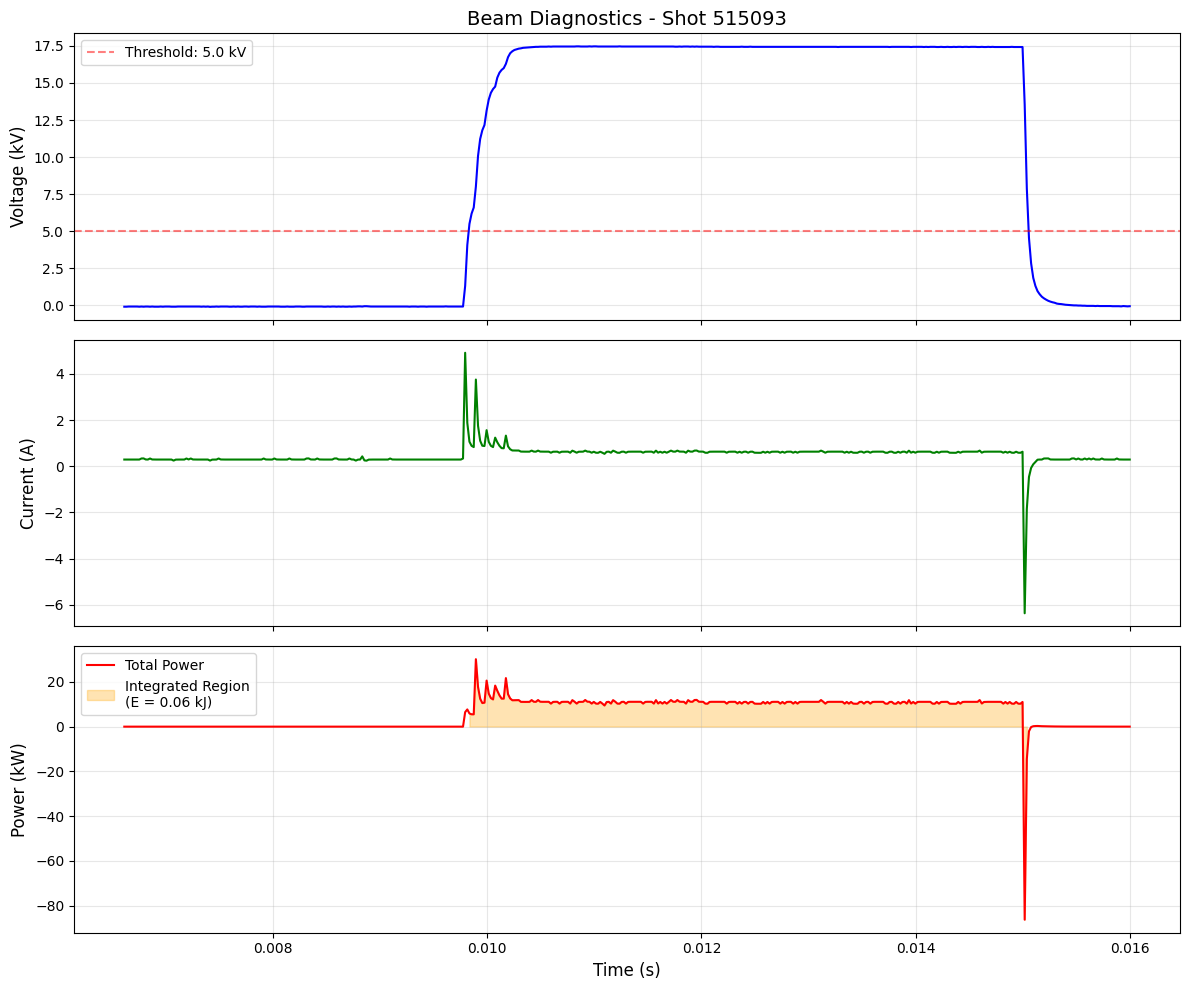


Beam-on duration: 0.0052 s (5.20 ms)
Average power during beam-on: 10.66 kW
Total energy delivered: 0.06 kJ

DATA FROM DATAFRAME

ΔT values for each thermocouple:
  TC            TC_Description  deltaT  beam_energy_kJ  deltaT_norm
TC14 NB Calorimeter 0 (center)   2.209           0.056       39.623
TC15  NB Calorimeter 1 (lower)   1.278           0.056       22.923
TC16  NB Calorimeter 2 (right)   1.260           0.056       22.600
TC17  NB Calorimeter 3 (upper)   1.661           0.056       29.793
TC18   NB Calorimeter 4 (left)   1.273           0.056       22.834

Beam Energy (from dataframe): 0.06 kJ
Beam Energy (manual fetch): 0.06 kJ

Average ΔT: 1.54 °C
Average ΔT/E: 27.5546 °C/kJ

COMPARISON WITH OTHER SHOTS:

Top 10 shots by normalized ΔT/E:
       file  avg_deltaT  avg_deltaT_norm  beam_energy_kJ
6-14_515093       1.536           27.555           0.056
6-14_515091       1.704            0.847           2.012
4-14_112163       1.598            0.837           1.909
4-14_515067 

In [44]:
# Investigate shot 515093 - why are the values so high?
shot_to_check = '6-14_515093'
shot_number = 515093

print(f"\n{'='*80}")
print(f"DETAILED ANALYSIS OF SHOT {shot_to_check} (shot number: {shot_number})")
print(f"{'='*80}\n")

# First, check which tree this shot should use
print("=== TREE SELECTION CHECK ===")
print(f"Shot number: {shot_number}")
if shot_number > 200000:
    print(f"✓ Shot {shot_number} > 200000, so using 'ltx_nbi' tree")
    treename = 'ltx_nbi'
    prefix = ''
else:
    print(f"✗ Shot {shot_number} <= 200000, so using 'ltx_b' tree")
    treename = 'ltx_b'
    prefix = '.oper_diags.ltx_nbi'

print(f"Tree: {treename}")
print(f"Prefix: '{prefix}'")
print(f"Full path for current: {prefix}.source_diags.i_hvps")

# Try to manually fetch the beam energy with detailed error reporting
print("\n=== MANUAL BEAM ENERGY FETCH ===")
v_thresh = 5000.0
try:
    tree = get_tree_conn(shot_number, treename=treename)
    print(f"✓ Successfully connected to tree '{treename}' for shot {shot_number}")
    
    try:
        (ti, ib) = get_data(tree, f'{prefix}.source_diags.i_hvps')
        print(f"✓ Got current data: {len(ti)} points, range [{ib.min():.2f}, {ib.max():.2f}] A")
    except Exception as e:
        print(f"✗ Error fetching current: {e}")
        ib, ti = None, None
    
    try:
        (tv, vb) = get_data(tree, f'{prefix}.source_diags.v_hvps')
        print(f"✓ Got voltage data: {len(tv)} points, range [{vb.min():.2f}, {vb.max():.2f}] V")
    except Exception as e:
        print(f"✗ Error fetching voltage: {e}")
        vb, tv = None, None
    
    if ib is not None and vb is not None:
        # Interpolate current to voltage time base
        ib_interp = np.interp(tv, ti, ib)
        pb = ib_interp * vb / 1000.0  # kW
        
        mask = vb > v_thresh
        if np.any(mask):
            tv_beam = tv[mask]
            pb_beam = pb[mask]
            beam_duration = tv_beam[-1] - tv_beam[0]
            avg_power = np.mean(pb_beam)
            total_energy = np.trapz(pb_beam, tv_beam)
            
            print(f"\n✓ Beam calculation successful:")
            print(f"  Beam duration: {beam_duration*1000:.2f} ms")
            print(f"  Average power: {avg_power:.2f} kW")
            print(f"  Total energy: {total_energy:.2f} kJ")
            
            # Create diagnostic plot
            print("\n=== CREATING BEAM DIAGNOSTIC PLOT ===")
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
            
            # Plot voltage
            ax1.plot(tv, vb/1000, 'b-', linewidth=1.5)
            ax1.axhline(y=v_thresh/1000, color='r', linestyle='--', alpha=0.5, 
                       label=f'Threshold: {v_thresh/1000:.1f} kV')
            ax1.set_ylabel('Voltage (kV)', fontsize=12)
            ax1.set_title(f'Beam Diagnostics - Shot {shot_number}', fontsize=14)
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            
            # Plot current
            ax2.plot(tv, ib_interp, 'g-', linewidth=1.5)
            ax2.set_ylabel('Current (A)', fontsize=12)
            ax2.grid(True, alpha=0.3)
            
            # Plot power
            ax3.plot(tv, pb, 'r-', linewidth=1.5, label='Total Power')
            ax3.fill_between(tv_beam, 0, pb_beam, alpha=0.3, color='orange', 
                           label=f'Integrated Region\n(E = {total_energy:.2f} kJ)')
            ax3.set_ylabel('Power (kW)', fontsize=12)
            ax3.set_xlabel('Time (s)', fontsize=12)
            ax3.grid(True, alpha=0.3)
            ax3.legend()
            
            plt.tight_layout()
            plt.show()
            
            print(f"\nBeam-on duration: {beam_duration:.4f} s ({beam_duration*1000:.2f} ms)")
            print(f"Average power during beam-on: {avg_power:.2f} kW")
            print(f"Total energy delivered: {total_energy:.2f} kJ")
            
        else:
            print(f"\n✗ No voltage above {v_thresh/1000:.1f} kV threshold (max voltage: {vb.max():.2f} V)")
            total_energy = np.nan
    else:
        print("\n✗ Could not calculate beam energy due to missing data")
        total_energy = np.nan
        
except Exception as e:
    print(f"✗ Failed to connect to tree: {e}")
    total_energy = np.nan

# Check if this shot exists in our data
print(f"\n{'='*80}")
print(f"DATA FROM DATAFRAME")
print(f"{'='*80}\n")

if shot_to_check in all_df['file'].values:
    shot_data = all_df[all_df['file'] == shot_to_check]
    
    print("ΔT values for each thermocouple:")
    print(shot_data[['TC', 'TC_Description', 'deltaT', 'beam_energy_kJ', 'deltaT_norm']].to_string(index=False))
    
    beam_energy = shot_data['beam_energy_kJ'].iloc[0]
    print(f"\nBeam Energy (from dataframe): {beam_energy:.2f} kJ")
    if 'total_energy' in locals() and not np.isnan(total_energy):
        print(f"Beam Energy (manual fetch): {total_energy:.2f} kJ")
        if abs(beam_energy - total_energy) > 0.01:
            print(f"⚠️  WARNING: Mismatch between stored and calculated beam energy!")
    
    print(f"\nAverage ΔT: {shot_data['deltaT'].mean():.2f} °C")
    print(f"Average ΔT/E: {shot_data['deltaT_norm'].mean():.4f} °C/kJ")
    
    # Compare to other shots
    print(f"\n{'='*60}")
    print("COMPARISON WITH OTHER SHOTS:")
    print(f"{'='*60}\n")
    
    # Calculate statistics for all shots
    all_shots_stats = all_df.groupby('file').agg({
        'deltaT': 'mean',
        'deltaT_norm': 'mean',
        'beam_energy_kJ': 'first'
    }).reset_index()
    all_shots_stats.columns = ['file', 'avg_deltaT', 'avg_deltaT_norm', 'beam_energy_kJ']
    all_shots_stats = all_shots_stats.sort_values('avg_deltaT_norm', ascending=False)
    
    print("Top 10 shots by normalized ΔT/E:")
    print(all_shots_stats.head(10).to_string(index=False))
    
    # Find the rank of shot 515093
    rank = all_shots_stats[all_shots_stats['file'] == shot_to_check].index[0] + 1
    print(f"\nShot {shot_to_check} ranks #{rank} out of {len(all_shots_stats)} shots")
    
    # Check if beam energy is unusually low
    avg_beam_energy = all_shots_stats['beam_energy_kJ'].mean()
    median_beam_energy = all_shots_stats['beam_energy_kJ'].median()
    print(f"\nAverage beam energy across all shots: {avg_beam_energy:.2f} kJ")
    print(f"Median beam energy across all shots: {median_beam_energy:.2f} kJ")
    print(f"Shot {shot_to_check} beam energy: {beam_energy:.2f} kJ")
    print(f"Ratio to average: {beam_energy/avg_beam_energy:.2%}")
    
    if beam_energy < avg_beam_energy * 0.5:
        print(f"\n⚠️  WARNING: This shot has unusually LOW beam energy!")
        print(f"   {beam_energy:.2f} kJ vs avg {avg_beam_energy:.2f} kJ ({beam_energy/avg_beam_energy:.1%} of average)")
        print("   This causes the normalized ΔT/E to be very high!")
        print("   The calorimeter still heated up, but with much less beam energy.")
    
else:
    print(f"Shot {shot_to_check} not found in data!")
